In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd as skrsvd
import glob, os


os.chdir(".")
files = []
for file in glob.glob("/home/BCCRC.CA/ssubedi/projects/experiments/asapp/resources/dice/*.csv"):
    files.append(file)

dfall = pd.DataFrame()

cts = []
for i,f in enumerate(files):

    df = pd.read_csv(f)
    df = df[df['Additional_annotations'].str.contains('protein_coding')].reset_index(drop=True)
    df = df.drop(columns=['Additional_annotations'])
    
    ct = os.path.basename(f).split('.')[0].replace('_TPM','')
    cols = [str(x)+'_'+ct for x in range(df.shape[1]-2)]
    df.columns = ['gene','length'] + cols
    
    if i == 0:
        dfall = df
    else:
        dfall = pd.merge(dfall,df,on=['gene','length'],how='outer')
    cts.append(ct)
    print(ct)




NK
THSTAR
TH1
B_CELL_NAIVE
TREG_MEM
TH2
TREG_NAIVE
MONOCYTES
M2
TFH
CD8_NAIVE
CD4_NAIVE
TH17


In [2]:
nz_cutoff = 10
dfall = dfall[dfall.iloc[:,2:].sum(1)>nz_cutoff].reset_index(drop=True)
genes = dfall['gene'].values
glens = dfall['length'].values
dfall = dfall.drop(columns=['gene','length'])


qt = QuantileTransformer(random_state=0)
dfall_q = qt.fit_transform(dfall)

mu_total = np.mean(dfall_q,axis=1)
 
scaler = StandardScaler()
dfall_q = pd.DataFrame(scaler.fit_transform(dfall_q.T).T,columns=dfall.columns)


u,d,v = skrsvd(dfall_q.to_numpy()/np.sqrt(dfall_q.shape[1]),n_components=50,random_state=0)
L_total = u * d

In [16]:
z = []
for i in range(1000):
    z_total = np.dot(L_total,np.random.normal(size=L_total.shape[1])) + mu_total
    z.append(z_total)

(array([ 11.,   5.,   6.,  12.,  11.,  11.,  11.,  14.,  19.,  15.,  18.,
         17.,  16.,  22.,  29.,  21.,  27.,  29.,  26.,  37.,  43.,  29.,
         43.,  40.,  62.,  59.,  62.,  81.,  83., 141.]),
 array([0.01484288, 0.04768145, 0.08052001, 0.11335858, 0.14619715,
        0.17903572, 0.21187429, 0.24471285, 0.27755142, 0.31038999,
        0.34322856, 0.37606712, 0.40890569, 0.44174426, 0.47458283,
        0.5074214 , 0.54025996, 0.57309853, 0.6059371 , 0.63877567,
        0.67161424, 0.7044528 , 0.73729137, 0.77012994, 0.80296851,
        0.83580707, 0.86864564, 0.90148421, 0.93432278, 0.96716135,
        0.99999991]),
 <BarContainer object of 30 artists>)

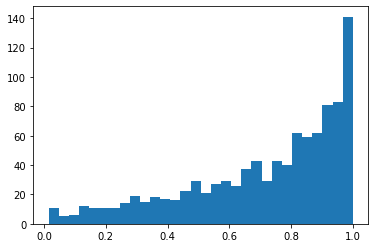

In [45]:
import scipy.stats as st
dfz = pd.DataFrame(z)
# dfz[dfz<20]=20
plt.hist(st.norm.cdf(dfz.iloc[:,100].values),bins=30)
# sns.scatterplot(dfz.iloc[:,0],dfz.iloc[:,100])

In [ ]:
def get_sc(L_total,mu_total,dfct,L_ct,mu_ct,pve_ct):
    z_total = np.dot(L_total,np.random.normal(size=L_total.shape[1])) + mu_total
    z_ct = np.dot(L_ct,np.random.normal(size=L_ct.shape[1])) + mu_ct
    x_sample = np.sort(dfct.apply(lambda x: np.random.choice(x), axis=1))
    z_sample = np.array([np.nan] * len(x_sample))
    z = z_ct * np.sqrt(pve_ct) + z_total * np.sqrt(1 - pve_ct)
    z_sample[np.argsort(z)] = x_sample
    return z_sample


In [ ]:
size= 2
pve_ct = 0.99
all_indx = []
dfsc = pd.DataFrame()
for ct in cts:
    dfct = dfall[[x for x in dfall.columns if ct in x]]
    dfct_q = dfall_q[[x for x in dfall_q.columns if ct in x]]

    mu_ct = dfct_q.mean(1)

    scaler = StandardScaler()
    dfct_q = pd.DataFrame(scaler.fit_transform(dfct_q.T).T)

    u,d,v = rsvd(dfct_q.to_numpy()/np.sqrt(dfct_q.shape[1]),n_components=50,random_state=0)
    L_ct = u * d

    ct_sc = []
    for i in range(size):
        ct_sc.append(get_sc(L_total,mu_total,dfct,L_ct,mu_ct,pve_ct))
    df_ctsc = pd.DataFrame(ct_sc,columns=genes)

    dfsc = pd.concat([dfsc,df_ctsc],axis=0,ignore_index=True)
    all_indx.append([ str(i) + '_' + ct.replace(' ','') for i in range(size)])

    print(ct)

In [ ]:
dfsc.index = np.array(all_indx).flatten()
dfsc

In [ ]:
# sns.scatterplot(x=np.log(dfsc.loc['0_NK']),y=np.log(dfsc.loc['1_NK']),s=2)
sns.scatterplot(x=np.log(dfsc.loc['1_NK']),y=np.log(dfsc.loc['0_M2']),s=2)